In [6]:
############################################################## Example codes to run GAN on MNIST dataset (hyper-parameters need to be tuned)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
latent_dim = 100
batch_size = 32
epochs = 50
lr = 0.0002

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize networks
generator = Generator(latent_dim)
discriminator = Discriminator()

# Optimizers
optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for real_images, _ in train_loader:
        real_images = real_images.view(-1, 784)

        # Train Discriminator
        optimizer_disc.zero_grad()
        
        # Real images
        real_labels = torch.ones(batch_size, 1)
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, real_labels)

        # Fake images
        noise = torch.randn(batch_size, latent_dim)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1)
        fake_output = discriminator(fake_images.detach())
        fake_loss = criterion(fake_output, fake_labels)

        # Total loss and backpropagation
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        # Train Generator
        optimizer_gen.zero_grad()
        
        fake_output = discriminator(fake_images)
        gen_loss = criterion(fake_output, real_labels)
        
        gen_loss.backward()
        optimizer_gen.step()

    print(f'Epoch [{epoch+1}/{epochs}] | D Loss: {disc_loss.item():.4f} | G Loss: {gen_loss.item():.4f}')
    

Epoch [1/50] | D Loss: 0.9740 | G Loss: 1.6870
Epoch [2/50] | D Loss: 0.5930 | G Loss: 5.5795
Epoch [3/50] | D Loss: 0.0889 | G Loss: 5.0834
Epoch [4/50] | D Loss: 0.1886 | G Loss: 3.8780
Epoch [5/50] | D Loss: 0.1166 | G Loss: 5.0015
Epoch [6/50] | D Loss: 1.3003 | G Loss: 11.6106
Epoch [7/50] | D Loss: 0.1862 | G Loss: 3.4827


KeyboardInterrupt: 

In [8]:
########################################### denoising diffusion probability model on MNIST dataset


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 128
epochs = 10
learning_rate = 0.001
image_size = 28 * 28
beta_start = 0.0001
beta_end = 0.02
timesteps = 1000

# Data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Linear schedule for beta
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)
alpha_cumprod_prev = torch.cat([torch.tensor([1.0]), alpha_cumprod[:-1]])

# Model definition
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
        )

    def forward(self, x, t):
        return self.net(x)

# Initialize model
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(-1, image_size)
        batch_size = images.size(0)

        # Sample random time step
        t = torch.randint(0, timesteps, (batch_size,), device=images.device).long()

        # Forward diffusion (adding noise)
        noise = torch.randn_like(images)
        alpha_t = alpha_cumprod[t].view(-1, 1)
        noisy_images = torch.sqrt(alpha_t) * images + torch.sqrt(1 - alpha_t) * noise

        # Predict noise
        noise_pred = model(noisy_images, t)

        # Compute loss
        loss = criterion(noise_pred, noise)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

Epoch 1/10, Loss: 0.6225
Epoch 2/10, Loss: 0.6063
Epoch 3/10, Loss: 0.5882
Epoch 4/10, Loss: 0.5902
Epoch 5/10, Loss: 0.5734
Epoch 6/10, Loss: 0.5622
Epoch 7/10, Loss: 0.5638
Epoch 8/10, Loss: 0.5854
Epoch 9/10, Loss: 0.5812
Epoch 10/10, Loss: 0.5617
Training complete.


Epoch 1/10, Loss: 0.6186
Epoch 2/10, Loss: 0.5786
Epoch 3/10, Loss: 0.5788
Epoch 4/10, Loss: 0.5793
Epoch 5/10, Loss: 0.5704
Epoch 6/10, Loss: 0.5820
Epoch 7/10, Loss: 0.5768
Epoch 8/10, Loss: 0.5558
Epoch 9/10, Loss: 0.5552
Epoch 10/10, Loss: 0.5443
Training complete.


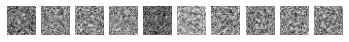

In [9]:
########################################### denoising diffusion probability model on MNIST dataset and generate random images


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
epochs = 10
learning_rate = 0.001
image_size = 28 * 28
beta_start = 0.0001
beta_end = 0.02
timesteps = 1000

# Data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Linear schedule for beta
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)
alpha_cumprod_prev = torch.cat([torch.tensor([1.0]), alpha_cumprod[:-1]])

# Model definition
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
        )

    def forward(self, x, t):
        return self.net(x)

# Initialize model
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(-1, image_size)
        batch_size = images.size(0)

        # Sample random time step
        t = torch.randint(0, timesteps, (batch_size,), device=images.device).long()

        # Forward diffusion (adding noise)
        noise = torch.randn_like(images)
        alpha_t = alpha_cumprod[t].view(-1, 1)
        noisy_images = torch.sqrt(alpha_t) * images + torch.sqrt(1 - alpha_t) * noise

        # Predict noise
        noise_pred = model(noisy_images, t)

        # Compute loss
        loss = criterion(noise_pred, noise)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Generate images
def generate_images(model, num_images, timesteps, image_size):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_images, image_size).to(next(model.parameters()).device)
        for t in reversed(range(timesteps)):
            beta_t = betas[t]
            alpha_t = alphas[t]
            alpha_t_cumprod = alpha_cumprod[t]
            alpha_t_cumprod_prev = alpha_cumprod_prev[t]

            noise_pred = model(x, torch.tensor([t]).to(x.device))

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            coef1 = (1 / torch.sqrt(alpha_t)) * (1 - alpha_t) / torch.sqrt(1 - alpha_t_cumprod)
            coef2 = torch.sqrt(1 - alpha_t_cumprod_prev) * beta_t / torch.sqrt(1 - alpha_t_cumprod)

            x = (1 / torch.sqrt(alpha_t)) * (x - coef1 * noise_pred) + coef2 * noise

    images = x.view(-1, 1, 28, 28)
    images = (images + 1) / 2
    return images

num_images = 10
fake_images = generate_images(model, num_images, timesteps, image_size)

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

      father       son
0   65.04851  59.77827
1   63.25094  63.21404
2   64.95532  63.34242
3   65.75250  62.79238
4   61.13723  64.28113
5   63.02254  64.24221
6   65.37053  64.08231
7   64.72398  63.99574
8   66.06509  64.61338
9   66.96738  63.97944
10  59.00800  65.24451
11  62.93203  65.35102
12  63.67063  65.67992
13  64.07386  65.43664
14  64.68851  65.29391
15  65.15466  64.79017
16  66.37353  65.01881
17  65.57704  65.54640
18  67.36765  65.08145
19  66.75929  65.49008
20  67.79764  65.13520
21  69.53480  65.51262
22  62.54014  66.58436
23  63.81016  66.37842
24  64.45650  66.14782
25  64.96650  65.97259
26  64.70662  65.95887
27  65.73829  66.45202
28  65.50141  65.74797
29  65.55416  65.97164
            father          son
count  1078.000000  1078.000000
mean     67.687097    68.684070
std       2.744868     2.814702
min      59.008000    58.507080
25%      65.787735    66.931232
50%      67.766600    68.615820
75%      69.602980    70.465970
max      75.433930    78.364790

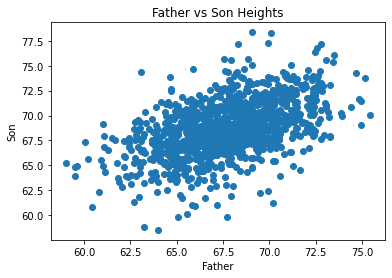

In [10]:
###  Father and Son's height dataset

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
url = "http://www.math.wustl.edu/~jmding/math3200/pearson.dat"
father_son = pd.read_csv(url, delim_whitespace=True, names=["father", "son"])

# Display the first 30 rows
print(father_son.head(30))

# Display summary statistics
print(father_son.describe())

# Plot the data
plt.scatter(father_son['father'], father_son['son'])
plt.xlabel('Father')
plt.ylabel('Son')
plt.title('Father vs Son Heights')
plt.show()

    year  age            maritl      race           education  \
0   2006   18  1. Never Married  1. White        1. < HS Grad   
1   2004   24  1. Never Married  1. White     4. College Grad   
2   2003   45        2. Married  1. White     3. Some College   
3   2003   43        2. Married  3. Asian     4. College Grad   
4   2005   50       4. Divorced  1. White          2. HS Grad   
5   2008   54        2. Married  1. White     4. College Grad   
6   2009   44        2. Married  4. Other     3. Some College   
7   2008   30  1. Never Married  3. Asian     3. Some College   
8   2006   41  1. Never Married  2. Black     3. Some College   
9   2004   52        2. Married  1. White          2. HS Grad   
10  2007   45       4. Divorced  1. White     3. Some College   
11  2007   34        2. Married  1. White          2. HS Grad   
12  2005   35  1. Never Married  1. White          2. HS Grad   
13  2003   39        2. Married  1. White     4. College Grad   
14  2009   54        2. M

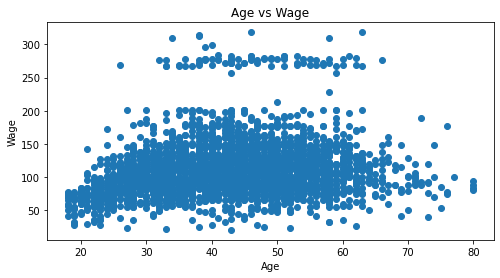

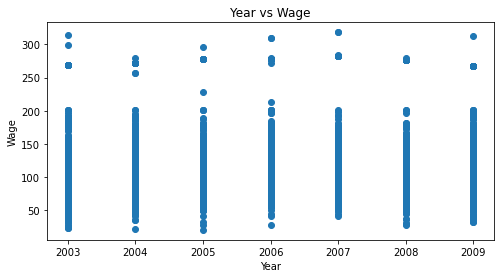

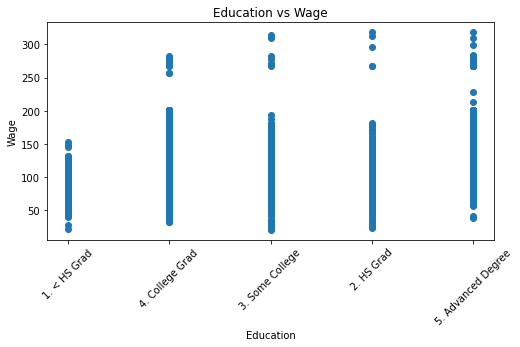

In [13]:
####  Wages Datasets

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
Wage = pd.read_csv('data/Wage.csv')

# Display the first 20 rows
print(Wage.head(20))

# Plot age vs wage
plt.figure(figsize=(8, 4))
plt.scatter(Wage['age'], Wage['wage'])
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Age vs Wage')
plt.show()

# Plot year vs wage
plt.figure(figsize=(8, 4))
plt.scatter(Wage['year'], Wage['wage'])
plt.xlabel('Year')
plt.ylabel('Wage')
plt.title('Year vs Wage')
plt.show()

# Plot education vs wage
plt.figure(figsize=(8, 4))
plt.scatter(Wage['education'], Wage['wage'])
plt.xlabel('Education')
plt.ylabel('Wage')
plt.title('Education vs Wage')
plt.xticks(rotation=45)
plt.show()

In [17]:
#####  Spam Datasets
###  The first 48 variables contain the frequency of the variable name (e.g., business) in the e-mail. If the variable name starts with 
###  num (e.g., num650) the it indicates the frequency of the corresponding number (e.g., 650). The variables 49-54 indicate the frequency
###  of the characters ‘;’, ‘(’, ‘[’, ‘!’, ‘\$’, and ‘\#’. The variables 55-57 contain the average, longest and total run-length of capital
###  letters. Variable 58 indicates the type of the mail and is either "nonspam" or "spam", i.e. unsolicited commercial e-mail.

import pandas as pd



# Load the dataset
spam = pd.read_csv('data/Spam.csv')

# Display column names
print(spam.columns.tolist())

# Display the first 10 rows
print(spam.head(10))

['make', 'address', 'all', 'num3d', 'our', 'over', 'remove', 'internet', 'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses', 'free', 'business', 'email', 'you', 'credit', 'your', 'font', 'num000', 'money', 'hp', 'hpl', 'george', 'num650', 'lab', 'labs', 'telnet', 'num857', 'data', 'num415', 'num85', 'technology', 'num1999', 'parts', 'pm', 'direct', 'cs', 'meeting', 'original', 'project', 're', 'edu', 'table', 'conference', 'charSemicolon', 'charRoundbracket', 'charSquarebracket', 'charExclamation', 'charDollar', 'charHash', 'capitalAve', 'capitalLong', 'capitalTotal', 'type']
   make  address   all  num3d   our  over  remove  internet  order  mail  ...  \
0  0.00     0.64  0.64    0.0  0.32  0.00    0.00      0.00   0.00  0.00  ...   
1  0.21     0.28  0.50    0.0  0.14  0.28    0.21      0.07   0.00  0.94  ...   
2  0.06     0.00  0.71    0.0  1.23  0.19    0.19      0.12   0.64  0.25  ...   
3  0.00     0.00  0.00    0.0  0.63  0.00    0.31      0.63   0.31  0.63  ..

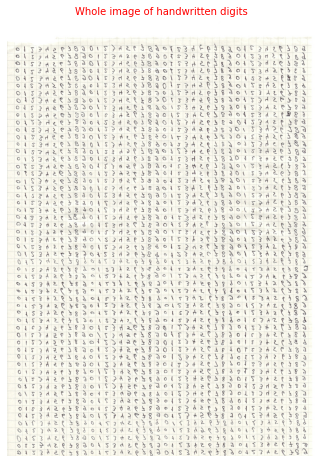

In [18]:
#######   Handwritten digits datasets


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import requests
from io import BytesIO

# Download and read the image
myurl = "https://raw.githubusercontent.com/RRighart/Digits/master/HandwrittenDigits.JPG"
response = requests.get(myurl)
img = mpimg.imread(BytesIO(response.content), format='jpeg')

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(np.flipud(img), cmap='gray', aspect='equal')
plt.axis('off')
plt.title("Whole image of handwritten digits", fontsize=10, color='red')
plt.show()

In [36]:

from igraph import Graph
import random

# Load the graph
polg = Graph.Read_GML("data/polblogs/polblogs.gml")

# Summary of the graph
print(polg.summary())

# Number of vertices
print("Number of vertices:", polg.vcount())

# Number of edges
print("Number of edges:", polg.ecount())

# Sample 10 edges
sample_edges = random.sample(list(range(1,polg.ecount())), 10)


# Print sampled edges
for ind in sample_edges:
    edge=polg.es[ind]
    source=edge.source
    target=edge.target
    print(f"The {ind}-th Edge: Source: {source}, Targe: {target}")

IGRAPH D--- 1490 19090 -- 
+ attr: id (v), label (v), source (v), value (v)
Number of vertices: 1490
Number of edges: 19090
The 18351-th Edge: Source: 780, Targe: 1249
The 528-th Edge: Source: 179, Targe: 1050
The 311-th Edge: Source: 1363, Targe: 1478
The 6314-th Edge: Source: 1252, Targe: 1054
The 4230-th Edge: Source: 1400, Targe: 825
The 10113-th Edge: Source: 1481, Targe: 1231
The 2847-th Edge: Source: 1, Targe: 154
The 9962-th Edge: Source: 453, Targe: 392
The 17283-th Edge: Source: 443, Targe: 169
The 13302-th Edge: Source: 1434, Targe: 1176


<ipython-input-36-494add78bb29>:5: RuntimeWarning: One or more unknown entities will be returned verbatim (&#38;). at src/io/gml.c:150
  polg = Graph.Read_GML("data/polblogs/polblogs.gml")


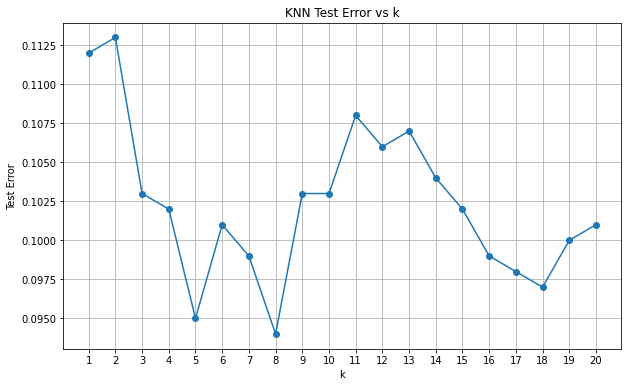

In [1]:
############ KNN on MNIST dataset


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Use a smaller subset for quicker computation
X, y = mnist.data[:5000], mnist.target[:5000]

# Preprocess the data
X = StandardScaler().fit_transform(X)
y = y.astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of k values
k_values = range(1, 21)
test_errors = []

# Run KNN for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    test_errors.append(test_error)

# Plot the test error vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, test_errors, marker='o')
plt.title('KNN Test Error vs k')
plt.xlabel('k')
plt.ylabel('Test Error')
plt.xticks(k_values)
plt.grid()
plt.show()



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2576559.14it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 141666.58it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1024859.52it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1704287.78it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch [0/100]  D loss: 0.0234  G loss: 5.8612


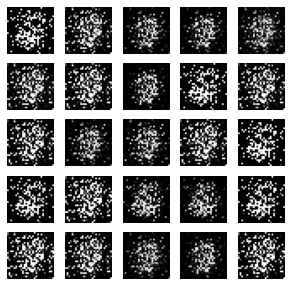

Epoch [1/100]  D loss: 0.0374  G loss: 5.9821
Epoch [2/100]  D loss: 0.0194  G loss: 6.7583
Epoch [3/100]  D loss: 0.0414  G loss: 5.3718
Epoch [4/100]  D loss: 0.3049  G loss: 1.6595
Epoch [5/100]  D loss: 0.1248  G loss: 3.4583
Epoch [6/100]  D loss: 0.2284  G loss: 3.0413
Epoch [7/100]  D loss: 0.2358  G loss: 3.4637
Epoch [8/100]  D loss: 0.1871  G loss: 4.5571
Epoch [9/100]  D loss: 0.1692  G loss: 2.9958
Epoch [10/100]  D loss: 0.2413  G loss: 3.4474


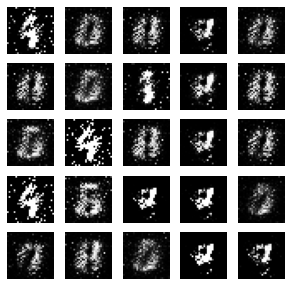

Epoch [11/100]  D loss: 0.3722  G loss: 3.2787
Epoch [12/100]  D loss: 0.3298  G loss: 2.7710
Epoch [13/100]  D loss: 0.1409  G loss: 3.6744
Epoch [14/100]  D loss: 0.2436  G loss: 2.2374
Epoch [15/100]  D loss: 0.2187  G loss: 2.2996
Epoch [16/100]  D loss: 0.4092  G loss: 1.7602
Epoch [17/100]  D loss: 0.3314  G loss: 2.2512
Epoch [18/100]  D loss: 0.2153  G loss: 2.3036
Epoch [19/100]  D loss: 0.2040  G loss: 2.7327
Epoch [20/100]  D loss: 0.2155  G loss: 1.8352


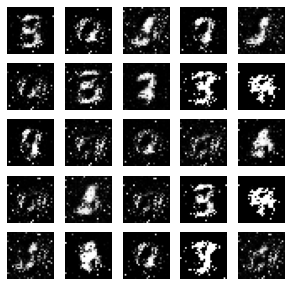

Epoch [21/100]  D loss: 0.3271  G loss: 1.4120
Epoch [22/100]  D loss: 0.3022  G loss: 3.4336
Epoch [23/100]  D loss: 0.3118  G loss: 1.7056
Epoch [24/100]  D loss: 0.3761  G loss: 1.9040
Epoch [25/100]  D loss: 0.2795  G loss: 2.2418
Epoch [26/100]  D loss: 0.1272  G loss: 2.7387
Epoch [27/100]  D loss: 0.1879  G loss: 3.5092
Epoch [28/100]  D loss: 0.2743  G loss: 2.4174
Epoch [29/100]  D loss: 0.1951  G loss: 2.3458
Epoch [30/100]  D loss: 0.3323  G loss: 3.4640


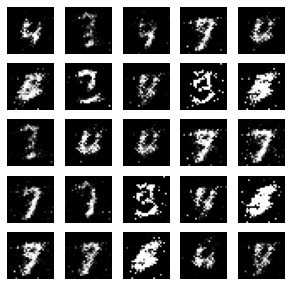

Epoch [31/100]  D loss: 0.1601  G loss: 2.6070
Epoch [32/100]  D loss: 0.1869  G loss: 2.1947
Epoch [33/100]  D loss: 0.3765  G loss: 2.3251
Epoch [34/100]  D loss: 0.2513  G loss: 2.0797
Epoch [35/100]  D loss: 0.2688  G loss: 2.5432
Epoch [36/100]  D loss: 0.4162  G loss: 1.4540
Epoch [37/100]  D loss: 0.1201  G loss: 3.0738
Epoch [38/100]  D loss: 0.1156  G loss: 2.5717
Epoch [39/100]  D loss: 0.1992  G loss: 2.8454
Epoch [40/100]  D loss: 0.1990  G loss: 3.4961


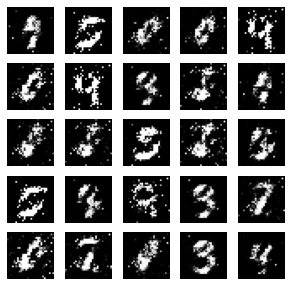

KeyboardInterrupt: 

In [2]:
########################################### GAN on MNIST dataset and generate random images



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 100
batch_size = 64
epochs = 100
lr = 0.0002
image_size = 28
channels = 1

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size * image_size * channels),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), channels, image_size, image_size)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * channels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss and optimizer
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        real = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Print progress
    print(f"Epoch [{epoch}/{epochs}]  D loss: {d_loss.item():.4f}  G loss: {g_loss.item():.4f}")

    # Generate and show sample images
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(25, latent_dim)
            gen_imgs = generator(z).detach().cpu()
            gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

            fig, axs = plt.subplots(5, 5, figsize=(5, 5))
            for ax, img in zip(axs.flatten(), gen_imgs):
                ax.imshow(img.squeeze(), cmap='gray')
                ax.axis('off')
            plt.show()

Smoothness 5: Training Error = 0.0625
Smoothness 5: Test Error = 11.5916
Smoothness 20: Training Error = 0.2501
Smoothness 20: Test Error = 0.2241
Smoothness 100: Training Error = 0.5761
Smoothness 100: Test Error = 0.7214


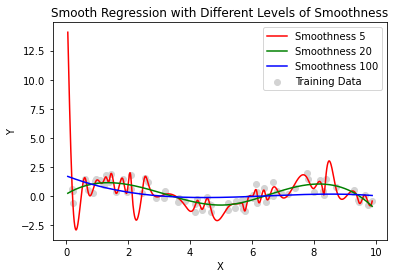

In [13]:
###################### spline regression with different smooth levels and corresponding training error and test error

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate synthetic data
np.random.seed(0)
x = np.sort(np.random.rand(100) * 10)
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

sorted_indices = np.argsort(x_train)
x_train = x_train[sorted_indices]
y_train = y_train[sorted_indices]


# Plot the original training data
plt.scatter(x_train, y_train, label='Training Data', color='lightgray')

# Fit smooth regression curves with different smoothness levels
smoothness_levels = [5,20,100]
colors = ['red', 'green', 'blue']

for s, color in zip(smoothness_levels, colors):
    spline = UnivariateSpline(x_train, y_train, s=s)
    xs = np.linspace(x.min(), x.max(), 1000)
    plt.plot(xs, spline(xs), label=f'Smoothness {s}', color=color)
    
    # Calculate and report training error
    y_train_fit = spline(x_train)
    training_error = mean_squared_error(y_train, y_train_fit)
    print(f'Smoothness {s}: Training Error = {training_error:.4f}')
    
    # Calculate and report test error
    y_test_fit = spline(x_test)
    test_error = mean_squared_error(y_test, y_test_fit)
    print(f'Smoothness {s}: Test Error = {test_error:.4f}')

# Customize plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Smooth Regression with Different Levels of Smoothness')
plt.legend()
plt.show()

K=1: Training Error = 0.0000
K=1: Test Error = 0.5778
K=5: Training Error = 0.2495
K=5: Test Error = 0.3391
K=10: Training Error = 0.2672
K=10: Test Error = 0.3121
K=20: Training Error = 0.3665
K=20: Test Error = 0.3426


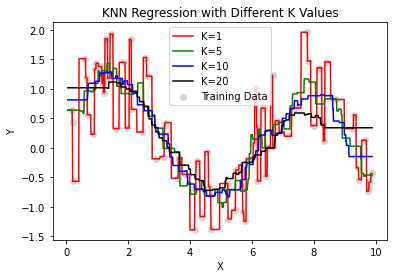

In [16]:
########### KNN regression, fitted curve with different K value, report training error and test error

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Generate synthetic data
np.random.seed(0)
x = np.sort(np.random.rand(100) * 10)
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)

# Reshape x for sklearn
x = x.reshape(-1, 1)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Plot the original training data
plt.scatter(x_train, y_train, label='Training Data', color='lightgray')

# K values to try
k_values = [1, 5,10,20]
colors = ['red', 'green', 'blue','black']

# Fit KNN regression for different K values
for k, color in zip(k_values, colors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)
    
    # Predict on a smooth range for plotting
    xs = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
    ys = knn.predict(xs)
    plt.plot(xs, ys, label=f'K={k}', color=color)
    
    # Calculate and report training error
    y_train_pred = knn.predict(x_train)
    training_error = mean_squared_error(y_train, y_train_pred)
    print(f'K={k}: Training Error = {training_error:.4f}')
    
    # Calculate and report test error
    y_test_pred = knn.predict(x_test)
    test_error = mean_squared_error(y_test, y_test_pred)
    print(f'K={k}: Test Error = {test_error:.4f}')

# Customize plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('KNN Regression with Different K Values')
plt.legend()
plt.show()

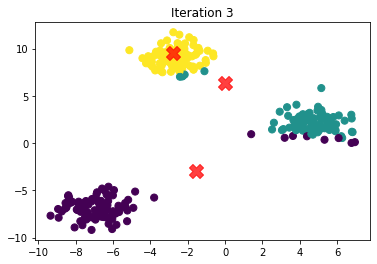

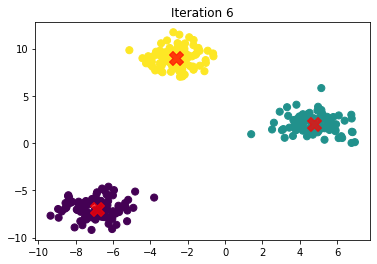

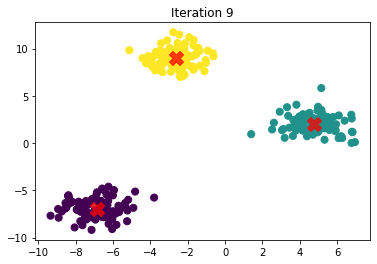

Mis-clustering Error: 0.0000


In [23]:
################################ K-means clustering, with clustering results shown clustering results


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score

# Generate synthetic data
np.random.seed(0)
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# Define a function to plot clusters
def plot_clusters(X, y_pred, centroids, iteration):
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
    plt.title(f'Iteration {iteration}')
    plt.show()

# Function to calculate mis-clustering error
def calculate_misclustering_error(y_true, y_pred):
    cost_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            cost_matrix[i, j] = np.sum((y_true == i) & (y_pred == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    return 1 - accuracy_score(y_true, [col_ind[i] for i in y_pred])

# Initialize KMeans
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=5, random_state=42, algorithm='full')

# Run K-means and plot every five iterations
iteration = 0
while iteration < 9:
    kmeans.fit(X)
    y_pred = kmeans.labels_
    centroids = kmeans.cluster_centers_
    plot_clusters(X, y_pred, centroids, iteration + 3)
    iteration += 3
    kmeans.max_iter += 3

# Calculate mis-clustering error
mis_clustering_error = calculate_misclustering_error(y_true, y_pred)
print(f'Mis-clustering Error: {mis_clustering_error:.4f}')

<ipython-input-32-c4d146af7387>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5)
<ipython-input-32-c4d146af7387>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5)
<ipython-input-32-c4d146af7387>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadri

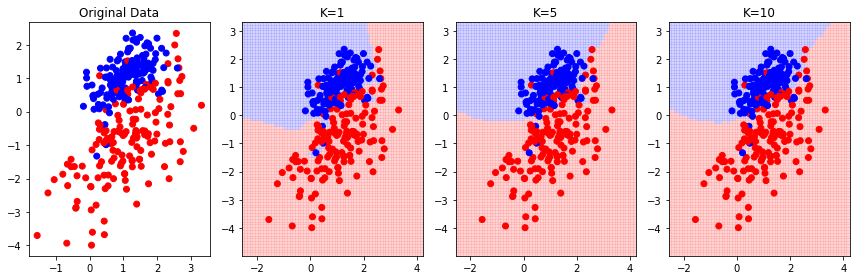

In [32]:
######################################### KNN classification


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Generate synthetic data
np.random.seed(0)
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)

# Plot the original data
plt.figure(figsize=(12, 4))
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# Define a function to plot decision boundaries
def plot_decision_boundary(clf, X, y, title, subplot):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 4, subplot)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.title(title)

# Plot original data
plt.subplot(1, 4, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.title('Original Data')

# K values to try
k_values = [1, 5,10]
for i, k in enumerate(k_values, start=2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    plot_decision_boundary(knn, X, y, f'K={k}', subplot=i)

plt.tight_layout()
plt.show()

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
